In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

Payoff of Call option
<img src='Profit of European call.png'>
Price of European call
<img src='Price of European call.png'>
Price of European call in Monte carlo simulation
<img src='Price of European call in Monte carlo simulation.png'>

In [2]:
def gen_sn(M, I, anti_paths=True, mo_math=True):
    """
        Instructions: Generate random numbers for simulation
        
        Patameters:
             M: number of time intervals for discretization
             I: number of paths to be simulated
             anti_paths: use of antithetic variates
             mo_math: use of moment matching
        
        Return:
             sn: random numbers for simulation by using the variance reduction technology
    """
    if anti_paths is True:
        sn = np.random.standard_normal((M + 1, int(I / 2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = np.random.standard_normal((M + 1, I))
    if mo_math is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

In [3]:
# the spot price
S0 = 100.
# the risk-free rate
rate = 0.05
# the volatility of underlying asset -- stock
sigma = 0.25
# time to maturity
T = 1.0
# the number of paths
I = 50000

# The static form

In [4]:
def EuropeCall_Static(K):
    """
    Instruction: Valuation of European call option in Black-Scholes-Merton by Mont Carlo simulation ( of index level at maturity )

    Parameters:
        k: strike price of the option

    Return:
        C0: the price of call option at time 0
    """
    # generate the random number dz, single path
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((rate - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator, discount and take average of paths
    C0 = np.exp(-rate * T) * 1 * np.sum(hT) / I
    return C0

EuropeCall_Static(105)

10.086094180988125

# The Dynamic differential form

In [5]:
def Europe_Dynamic(K, option='call'):
    """
        Instruction:
            Valuation of European option in Black-Scholes-Merton by Monte Carlo simulation(of index level paths)
       
        Parameters:
            K:（positive）strike price of the option
            option:
    
        Return:
            C0: the price of option as time 0
    """
    M = 50
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    # generate the random number dz
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((rate - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = np.exp(-rate * T) * 1 / I * np.sum(hT)
    return C0

In [6]:
print(Europe_Dynamic(K=110.,option='call'))
print(Europe_Dynamic(K=110.,option='put'))

8.054156986407085
12.714633588186631


# The American Option

In [7]:
def American_Option(K, option='call'):
    """
    Instructions:
        Valuation of American option in Black-Scholes-Merton by Monte Carlo simulation by LSM algorithm
    
    Parameters
        K: (positive) strike price of the option
        option: type of the option to be valued ('call','put')
        
    Returns:
        C0: estimated present value of American call option
    """
    M = 50
    dt = T / M
    df = np.exp(-rate * dt)
    # simulation of index levels
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((rate - 0.5 * sigma ** 2) * dt
                                 + sigma * np.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        h = np.maximum(S - K, 0)
    else:
        h = np.maximum(K - S, 0)
    # LSM algorithm
    V = np.copy(h)
    for t in range(M - 1, 0, -1):
        reg = np.polyfit(S[t], V[t + 1] * df, 7)
        C = np.polyval(reg, S[t])
        V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
    # MSC estimator
    C0 = df * 1 / I * np.sum(V[1])
    return C0


In [8]:
print(American_Option(110.,option='call'))
print(American_Option(110.,option='put'))

7.860278363784714
13.653368657194042


#  Early exercise premium
The value of European options lies below the value of American options.The difference between them is often referred to as an early exercise premium.
Now, we estimate the premium by comparing the European and American option values within the same exercise price range as before.This time we choose the put option.

In [9]:
euro_res = []
amer_res =[]

k_list = np.arange(80., 120.1, 5.)
for K in k_list:
    euro_res.append(Europe_Dynamic(K,'put'))
    amer_res.append(American_Option(K,'put'))
euro_res = np.array(euro_res)
amer_res = np.array(amer_res)

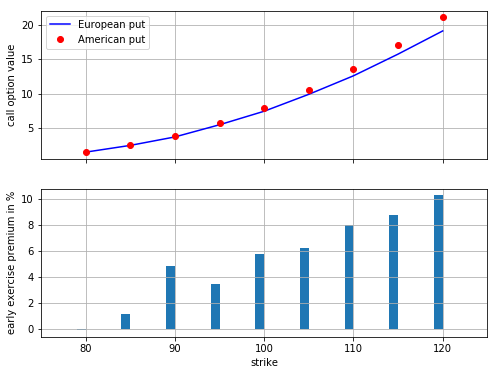

In [10]:
fig, (ax1 ,ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax1. plot(k_list, euro_res,'b', label='European put')
ax1. plot(k_list, amer_res,'ro',label='American put')
ax1.set_ylabel('call option value')
ax1.grid(True)
ax1.legend(loc=0)

wi = 1.0
ax2.bar(k_list - wi / 2, (amer_res - euro_res) / euro_res * 100, wi)
ax2.set_xlabel('strike')
ax2.set_ylabel('early exercise premium in %')
ax2.set_xlim(left=75, right=125)
ax2.grid(True)